In [380]:
import pandas as pd

In [381]:
customers = pd.read_csv('/content/drive/MyDrive/zeotap-data/Customers.csv')
transactions = pd.read_csv('/content/drive/MyDrive/zeotap-data/Transactions.csv')

In [382]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB


In [383]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 54.8+ KB


In [384]:
agg_transactions = transactions.groupby('CustomerID').agg(
    total_spending=pd.NamedAgg(column='TotalValue', aggfunc='sum'),
    purchase_frequency=pd.NamedAgg(column='TotalValue', aggfunc='count'),
    avg_transaction_value=pd.NamedAgg(column='TotalValue', aggfunc='mean')
).reset_index()

In [385]:
customers = pd.merge(customers, agg_transactions, on='CustomerID', how='left')

In [386]:
customers.columns

Index(['CustomerID', 'CustomerName', 'Region', 'SignupDate', 'total_spending',
       'purchase_frequency', 'avg_transaction_value'],
      dtype='object')

In [387]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
customers['SignupMonth'] = customers['SignupDate'].dt.month
customers['SignupYear'] = customers['SignupDate'].dt.year

In [388]:
customers = pd.get_dummies(customers, columns=['Region'], prefix=['Region'], drop_first=True)
customers = customers.fillna(0)

In [389]:
customers.columns

Index(['CustomerID', 'CustomerName', 'SignupDate', 'total_spending',
       'purchase_frequency', 'avg_transaction_value', 'SignupMonth',
       'SignupYear', 'Region_Europe', 'Region_North America',
       'Region_South America'],
      dtype='object')

In [390]:
# print(customers[['total_spending_x', 'total_spending_y']].head())
# customers = customers.drop(columns=['total_spending_x', 'purchase_frequency_x', 'avg_transaction_value_x'])

# Rename '_y' columns to simpler names
customers = customers.rename(columns={
    'total_spending_y': 'total_spending',
    'purchase_frequency_y': 'purchase_frequency',
    'avg_transaction_value_y': 'avg_transaction_value'
})

In [391]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
features = ['SignupMonth', 'SignupYear', 'total_spending', 'purchase_frequency', 'avg_transaction_value', 'Region_Europe', 'Region_North America',
       'Region_South America']

In [392]:
# scaler = StandardScaler()
imputer = SimpleImputer(strategy='median')
customers[features] = imputer.fit_transform(customers[features])

In [393]:
scaler = RobustScaler()
customers[features] = scaler.fit_transform(customers[features])

# scaler = StandardScaler()
# customers[features] = scaler.fit_transform(customers[features])

In [394]:
customers['spending_frequency'] = customers['total_spending'] * customers['purchase_frequency']
customers['avg_spending_ratio'] = customers['total_spending'] / (customers['avg_transaction_value'] + 1e-6)

new_features = ['spending_frequency', 'avg_spending_ratio']
customers[new_features] = scaler.fit_transform(customers[new_features])
features = features + new_features

In [395]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score

kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
customers['Cluster'] = kmeans.fit_predict(customers[features])

db_index = davies_bouldin_score(customers[features], customers['Cluster'])
silhouette_avg = silhouette_score(customers[features], customers['Cluster'])
ch_score = calinski_harabasz_score(customers[features], customers['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")
print(f"Calinski Harabasz Score: {ch_score}")

Davies-Bouldin Index: 0.2977270201620875
Silhouette Score: 0.6221656435765561
Calinski Harabasz Score: 77024.83847979835


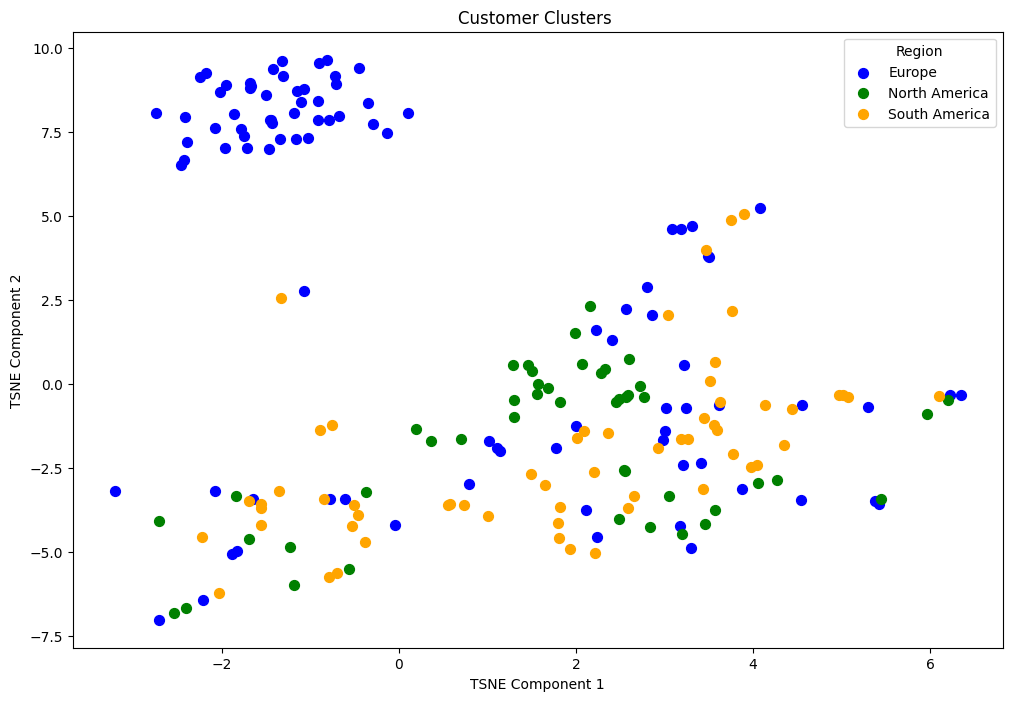

In [396]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

kmeans = KMeans(n_clusters=3, random_state=42, n_init=40)
customers['Cluster'] = kmeans.fit_predict(customers[features])
# tsne = TSNE(n_components=2, random_state=42)
tsne = TSNE(n_components=2, perplexity=60, learning_rate=600, random_state=42)

tsne_features = tsne.fit_transform(customers[features])
# pca = PCA(n_components=2)
# pca_features = pca.fit_transform(customers[features])
region_colors = {
    "Europe": "blue",
    "North America": "green",
    "South America": "orange",
}

customers['Region_Label'] = customers[['Region_Europe', 'Region_North America', 'Region_South America']].idxmax(axis=1)
customers['Region_Label'] = customers['Region_Label'].map({
    "Region_Europe": "Europe",
    "Region_North America": "North America",
    "Region_South America": "South America"
})



plt.figure(figsize=(12, 8))
for region, color in region_colors.items():
    subset = customers[customers['Region_Label'] == region]
    plt.scatter(tsne_features[subset.index, 0], tsne_features[subset.index, 1], c=color, label=region, s=50)


# plt.figure(figsize=(10, 6))
# plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=customers['Cluster'], cmap='viridis', s=50)
plt.legend(title="Region")
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('Customer Clusters ')
plt.show()
